# Imports, Read Data File

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
import time
import os
import random
import joblib

In [2]:
dataset = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
                         filepath_or_buffer = './data/2018-01-01__2019-01-01__NConservatory__allMerged.csv')
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert('America/Los_Angeles')

# **Reorder Columns of Dataset**

In [3]:
orderedSensorList = ( 'co2_1','co2_2', 'co2_3', 'co2_4', 'temp_1', 'temp_2', 'temp_3', 'temp_4', 'dew_1','dew_2', 'dew_3', 
                     'dew_4', 'relH_1', 'relH_2', 'relH_3', 'relH_4', 'externTemp_1', 'externHumid_1', 'externSunrise_1', 'externCondition_1' )
orderedDataset = dataset.reindex( index = dataset.index, columns = orderedSensorList )

# **Separate Weekday and Weekend**

In [4]:
dayIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.dayofweek/6, decimals=2), 
                       name='dayIndex')
hourIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.hour/24, decimals=2), 
                       name='hourIndex')
orderedDatasetTimeReference = pd.concat([orderedDataset, hourIndexDF, dayIndexDF], axis=1)

In [5]:
saturdayVal = np.round(5/6,decimals=2)
sundayVal = np.round(6/6,decimals=2)

weekdayData = orderedDatasetTimeReference[ ( dayIndexDF != saturdayVal) &( dayIndexDF != sundayVal) ]
weekendData = orderedDatasetTimeReference[ ( dayIndexDF == saturdayVal) | (dayIndexDF == sundayVal) ]

weekdayData.shape, weekendData.shape

((25033, 22), (9901, 22))

# **Rescale and Normalize data, focus on Weekdays**

In [6]:
continuousData = weekdayData.values[:, 0:17] # first 17 sensors are continuous valued
categoricalData = weekdayData.values[:, 17:]

standardScaler = StandardScaler()
standardScaler.fit( continuousData )

minMaxScaler = MinMaxScaler()
minMaxScaler.fit( categoricalData )

scaledContinuousData = standardScaler.transform(continuousData)
scaledCategoricalData = minMaxScaler.transform(categoricalData)

weekdayData_scaled =  pd.DataFrame( index = weekdayData.index,
                                    data = np.hstack( (scaledContinuousData, scaledCategoricalData)),
                                    columns = weekdayData.columns)

In [7]:
weekdayData_scaled.shape

(25033, 22)

# **Build Sliding Window data**

In [8]:
def build_train_data ( inputDataframe, outputFilename, advanceTimedeltaStr = '15 min' ):
    npFilename = outputFilename + '.npy'
    npFilenameSamplebounds = outputFilename + '_sampleBounds' + '.npy'
    rebuildFlag = True # flips if file exists in cache and user agrees to restore

    windowCounter = correctLenWindows = fixedWindows = 1
    trimNeededWindows = extensionNeededWindows = 1
    sumExtensionAmount = sumTrimAmount = 0
    
    def extract_one_day( startTime, endTime, idealIndex, nExtensionAttempts=10 ):        
        nonlocal correctLenWindows, trimNeededWindows, extensionNeededWindows, sumExtensionAmount, sumTrimAmount, fixedWindows
        oneDay = inputDataframe[ (inputDataframe.index >= startTime) & (inputDataframe.index < endTime)]
        
        if len(oneDay) == len(idealIndex):
            correctLenWindows += 1

        # available data in day range is too long -- trimming required
        if len(oneDay) > len(idealIndex):
            trimNeededWindows += 1
            sumTrimAmount += len(oneDay) - len(idealIndex)
            oneDay = oneDay.iloc[0:len(idealIndex)]
        
        # available data in day range is of insufficient length -- extension required 
        if len(oneDay) < len(idealIndex):
            extensionNeededWindows += 1
            sumExtensionAmount += len(idealIndex) - len(oneDay)
            
            oneDay = None
            # attempt to extend one sample at a time up to nExtensionAttempts
            for iExtensionAttempt in range( nExtensionAttempts ):
                endTime += pd.Timedelta( advanceTimedeltaStr)
                extendedDay = inputDataframe[ (inputDataframe.index >= startTime) & (inputDataframe.index < endTime)]
                # sucessfully extened data slice
                if len( extendedDay) == len( idealIndex ):
                    fixedWindows += 1
                    oneDay = extendedDay
                    break
        
        # only happens when available data requires extension beyond nExtensionAttempts
        if oneDay is None:
            return None, None, None
        
        assert ( len(oneDay) == len(idealIndex) )
        return oneDay.values.reshape(1,-1, order = 'F'), oneDay.index[0], oneDay.index[-1]
    
    
    # check cache
    if Path(npFilename).is_file() and Path(npFilenameSamplebounds).is_file():
        print('created on: {} \n\t size: {} MB'.format( time.ctime(os.path.getctime(npFilename)), 
                                                        Path(npFilename).stat().st_size / 1e6 ))
        #shouldRebuild = input('load from cache? (y/n): ')
        shouldRebuild = 'y' # For now keep as yes, so don't have to keep typing in input
        if 'y' == shouldRebuild:
            npTrainMatrix = np.load(npFilename, allow_pickle=True) # load from cache
            sampleIndexBounds = np.load(npFilenameSamplebounds, allow_pickle=True)
            rebuildFlag = False
    
    if rebuildFlag:
        npTrainMatrix = None
        sampleIndexBounds = None
        npTestMatrix = None

        startTime = inputDataframe.index[0]
        while(1):
            endTime = startTime + pd.Timedelta('1 day');
            
            # terminate window extraction once end of dataset is reached
            if startTime > inputDataframe.index[-1] or endTime > inputDataframe.index[-1]:
                break
            
            # generate an ideal index [ 96 x 15 min samples from current startTime ]
            idealIndex = pd.date_range(start=startTime, end=endTime, freq='15T', closed='left' );
            
            # ensure that current window is a weekday
            if (idealIndex.dayofweek < 5).all():
                
                # gather data from sensor streams going one day forward
                dataWindow, windowStartIndex, windowEndIndex = extract_one_day ( startTime, endTime, idealIndex)
                
                # dataWindow is none only when more than ~10 samples are missing                
                if dataWindow is not None:                
                    windowCounter += 1
                    
                    # first iteration is a direct assignment, all others require appending 
                    if npTrainMatrix is None:
                        npTrainMatrix = dataWindow;
                        sampleIndexBounds = np.array([windowStartIndex, windowEndIndex]);
                    else:
                        assert( dataWindow.shape[1] == npTrainMatrix.shape[1] ) # import ipdb; ipdb.set_trace()
                        npTrainMatrix = np.append( npTrainMatrix, dataWindow, axis = 0 );
                        sampleIndexBounds = np.append( sampleIndexBounds, np.array([windowStartIndex, windowEndIndex]) , axis = 0);
                        
            else:
                pass # skipping -- day segment includes a piece of the weekend
            
            avgTrim = np.round(sumTrimAmount/trimNeededWindows, decimals=2);
            avgExtend = np.round(sumExtensionAmount/extensionNeededWindows, decimals=2);
            
            # advance to next sample
            startTime = startTime + pd.Timedelta(advanceTimedeltaStr);

        print('nWindows {} - nCorrect {}; nTrimNeeded {} | avg.trim {}; nExtendNeeded {} | avg.ext {} | fixedViaExtension {}'.format(windowCounter, correctLenWindows, 
                       trimNeededWindows, avgTrim, extensionNeededWindows, avgExtend, fixedWindows), end='\r')

        print('\nwriting to cache')
        
        # save to cache
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        np.save(npFilename, npTrainMatrix)
        np.save(npFilenameSamplebounds, sampleIndexBounds)

    if sampleIndexBounds.shape[0] != npTrainMatrix.shape[0]:
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        
    return npTrainMatrix, sampleIndexBounds

In [9]:
%%time
outputFilename = './data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef'
npDataMatrix, sampleIndexBounds = build_train_data ( weekdayData_scaled, outputFilename )

created on: Sun Aug 16 23:01:20 2020 
	 size: 338.0384 MB
CPU times: user 438 ms, sys: 109 ms, total: 547 ms
Wall time: 3.55 s


In [10]:
npDataMatrix.shape

(20007, 2112)

# Shuffle and Split into Training and Validation Data

Training and validation data come out of npDataMatrix, testing data has its own data file

In [11]:
np.random.shuffle(npDataMatrix) # Shuffle rows of data matrix
npValMatrix = npDataMatrix[0:2000,:] # Take first 4000 rows (20%) for validation data
npTrainMatrix = npDataMatrix[2000:,:] # Take rest as training data

In [12]:
npValMatrix.shape, npTrainMatrix.shape

((2000, 2112), (18007, 2112))

# Load in Test Data, Insert Anomalies into Test Data

In [13]:
# test_dataset_2019 already has 200 anomalies in the data
npTestMatrix = joblib.load('./test_data/test_dataset_2019.numpy')
npTestMatrixCopy = np.copy(npTestMatrix) # Copy will not be touched by inserted anomalies, incase of need of clean test dataset
npTestMatrix.shape

(9898, 2112)

In [14]:
# Assuming for now an anomaly is a series of readings from a single sensor that is off of normal values by some difference

def insert_anomalies(npTestMatrix):
    # Convert numpy matrix to pandas dataframe
    pdTestWindowDF = pd.DataFrame(npTestMatrix)
    
    # Inject 1000 anomalies into test dataset, to go along with 200 anomalies they put in
    anom = pdTestWindowDF.iloc[0:1000,:]
    clean = pdTestWindowDF.iloc[1000:,:]
    
    for i in range(len(anom)):
        row = anom.iloc[i] # Get row in anom dataframe
        # Insert anomaly into 1 sensor input somewhere within row
        randSensor = random.randint(0,15) # Choose one sensor to mess readings for
        sensorReadingIndexStart = randSensor * 96

        for j in range(96):    
            if (i % 2 == 0):
                row[sensorReadingIndexStart + j] += 4 # Add 4 to each sensor reading, indicating a faulty sensor
            else:
                row[sensorReadingIndexStart + j] -= 4 # Subtract 4 to each sensor reading, indicating a faulty sensor
    
    # Add label column to indicate what windows contain an anomaly when anom and clean are joined back together
    anom.loc[:,'label'] = 1
    clean.loc[:,'label'] = 0
    
    # Concatenate pd dataframes back together, convert back to numpy matrix for testing
    pdTestDFWithAnom = pd.concat([anom,clean])
    pdTestDFWithAnom = pdTestDFWithAnom.sample(frac=1) # Shuffle, keep dataframe for later
    print(pdTestDFWithAnom.shape, type(pdTestDFWithAnom))
    
    # Convert to numpy matrix, delete anomaly label from numpy matrix (doesn't need to go into model)
    npTestMatrixWithAnom = pdTestDFWithAnom.to_numpy()
    npTestMatrixWithAnom = np.delete(npTestMatrixWithAnom, np.s_[2112], axis=1)
    
    return npTestMatrixWithAnom, pdTestDFWithAnom


In [15]:
#npTestMatrixWithAnom, pdTestDFWithAnom = insert_anomalies(npTestMatrix)
# Not inserting anomalies anymore, testing for 200 anomalies already embedded in data
npTestMatrixWithAnom = np.copy(npTestMatrix)
npTestMatrixWithAnom.shape, type(npTestMatrixWithAnom)

# pdTestDFWithAnom has label 1 or 0 for anomalies, npTestMatrixWithAnom does not have the label

((9898, 2112), numpy.ndarray)

# **Build Model**

In [16]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

In [17]:
dataLoaderTrain = DataLoader( npTrainMatrix.astype('float32'), batch_size = 20, shuffle = True )
dataLoaderValid = DataLoader( npValMatrix.astype('float32'), batch_size = 20, shuffle = True )
#dataLoaderTest = DataLoader( npTestMatrixWithAnom.astype('float32'), batch_size = 1, shuffle = False )

In [18]:
inputDimensionality = npTrainMatrix.shape[1]

model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid(),
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)
# Layer sizes: 2112 / 1056 / 528 / 211 / 528 / 1056 / 2112

# **Train Model**

In [19]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

In [20]:
def train_model ( model, dataLoaderTrain, dataLoaderValidation, targeDevice, nEpochs = 10 ):
    model = model.to( targetDevice )
    
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    trainLossHistory = []
    validationLossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):
        # For training set
        cumulativeLossTrain = 0
        for i, iInputBatch in enumerate( dataLoaderTrain ):
            iInputBatch = iInputBatch.to( targetDevice )
            optimizer.zero_grad()
            predictions = model.forward(iInputBatch)
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLossTrain += loss.item() # gets scaler value held in the loss tensor
            loss.backward()
            optimizer.step()
        
        print( 'epoch {} of {} -- cumulative loss: {}'.format(iEpoch, nEpochs, cumulativeLossTrain))
        trainLossHistory += [ cumulativeLossTrain / len(dataLoaderTrain.dataset) ]
        
        # For validation set, not affecting gradients of model
        cumulativeLossValidation = 0
        with torch.no_grad():
            for i, iInputBatch in enumerate( dataLoaderValidation ):
                iInputBatch = iInputBatch.to( targetDevice )
                predictions = model.forward(iInputBatch)
                loss = lossFunction( predictions, iInputBatch )
                cumulativeLossValidation += loss.item()
            validationLossHistory += [ cumulativeLossValidation / len(dataLoaderValidation.dataset) ]
        
        
    return model, trainLossHistory, validationLossHistory

In [21]:
startTime = time.time()
model, trainLossHistory, validLossHistory = train_model( model, dataLoaderTrain, dataLoaderValid, targetDevice, nEpochs = 15 )
print('elapsed time : {} '.format(time.time() - startTime))

epoch 0 of 15 -- cumulative loss: 336.4317979067564
epoch 1 of 15 -- cumulative loss: 133.64261586219072
epoch 2 of 15 -- cumulative loss: 103.33828602731228
epoch 3 of 15 -- cumulative loss: 86.42970903217793
epoch 4 of 15 -- cumulative loss: 76.88007126748562
epoch 5 of 15 -- cumulative loss: 72.42924738675356
epoch 6 of 15 -- cumulative loss: 69.32816802337766
epoch 7 of 15 -- cumulative loss: 67.30349296331406
epoch 8 of 15 -- cumulative loss: 65.45948706939816
epoch 9 of 15 -- cumulative loss: 63.58176576346159
epoch 10 of 15 -- cumulative loss: 62.1478776820004
epoch 11 of 15 -- cumulative loss: 60.75211137533188
epoch 12 of 15 -- cumulative loss: 59.252523716539145
epoch 13 of 15 -- cumulative loss: 57.750796776264906
epoch 14 of 15 -- cumulative loss: 56.11397357657552
elapsed time : 81.06574487686157 


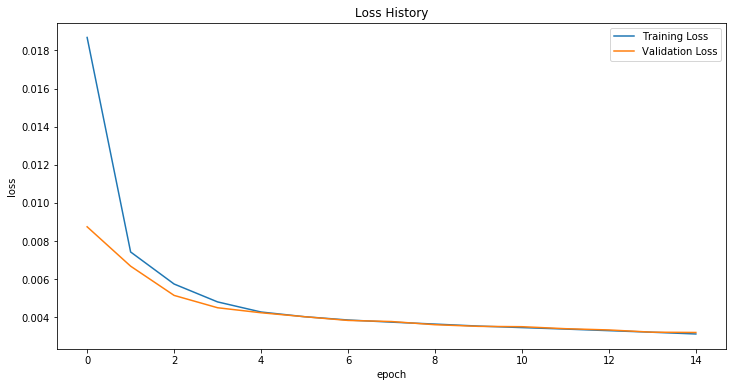

In [22]:
plt.figure(figsize=(12,6))
plt.plot(trainLossHistory)
plt.plot(validLossHistory)
plt.title('Loss History'); 
plt.xlabel('epoch'); 
plt.ylabel('loss');
plt.legend(['Training Loss', 'Validation Loss'])

# **Evaluate Performance**

### Single sample reconstruction visualization

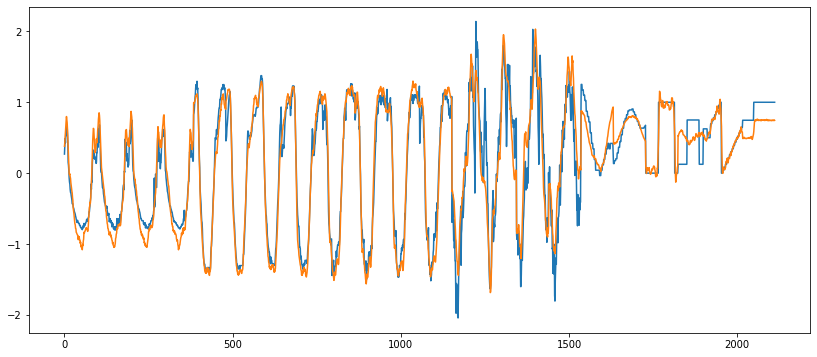

In [45]:
# Visualizing 1 sample reconstruction from npTestMatrixWithAnom / npTrainMatrix / npTestMatrixCopy
sample = torch.from_numpy(npTestMatrixCopy[0]).float() # get first row, type needs to be a torch tensor
reconstruction = model.forward(sample.to(targetDevice))
plt.figure(figsize=(14,6))
plt.plot(sample.numpy())
plt.plot(reconstruction.data.cpu().numpy())

### Run training and testing samples again through trained model, get Loss and MAE values

In [24]:
def get_reconstruction_loss_vals( model, npDataMatrix, targetDevice ):
    # Pass data through model, get MAE loss values. Can use for training or testing data to get MAE loss values
    lossItemsList = []
    lossItemsSumList = []
    predictionsList = []
    
    for i in range(len(npDataMatrix)):
        sample = torch.from_numpy(npDataMatrix[i]).float() # get one row, type needs to be a torch tensor
        reconstruction = model.forward(sample.to(targetDevice)) # Send through model

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error_array = np.absolute( (reconstructionNumpy - sampleNumpy) ) # Difference in prediction and actual value
        
        lossItemsList.append(error_array)
        lossItemsSumList.append(np.sum(error_array))
        predictionsList.append(reconstructionNumpy)
        
    return lossItemsList, predictionsList

In [25]:
# Error metrics: MAE, MAPE, SMAPE, MSE, RMSE
# Using Mean Absolute Error as error metric for now, highest MAE value will be threshold formula is
# np.mean( abs(orig_vals - pred_vals) )

# Function receives a loss item list, returns list of Mean Absolute Error values for each sample
def MAE(lossItemsList):
    MAE_val_list = np.mean(lossItemsList, axis=1) # List of max MAE vals from each sample
    return MAE_val_list


In [26]:
# Get MAE loss values for training data, use highest MAE loss value from training as threshold for anomalies in test data
trainset_loss_items_list, trainset_prediction_items_list = get_reconstruction_loss_vals(model, npTrainMatrix, targetDeviceGPU)
trainset_MAE_loss_vals = MAE(trainset_loss_items_list)

In [27]:
# Get loss values for test data that does not have anomalies in it, for visualization
test_loss_items_list, test_prediction_items_list = get_reconstruction_loss_vals( model, npTestMatrixWithAnom, targetDeviceGPU)
test_MAE_loss_vals = MAE(test_loss_items_list)
len(test_loss_items_list), type(test_loss_items_list[0])

(9898, numpy.ndarray)

Histogram of training/testing MAE values - Anomaly MAE values start to be seen around 3.3 average MAE


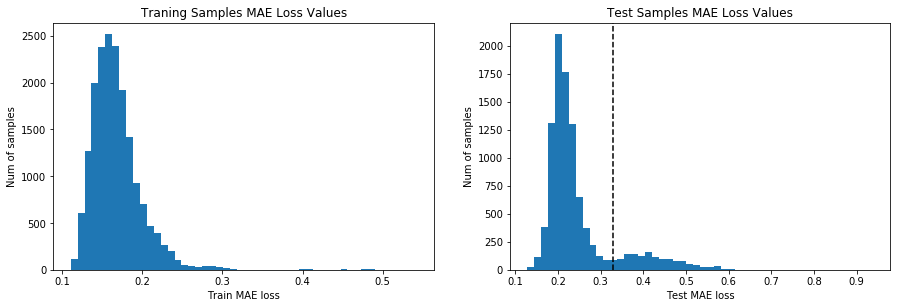

In [28]:
print("Histogram of training/testing MAE values - Anomaly MAE values start to be seen around 3.3 average MAE")
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.hist(trainset_MAE_loss_vals, bins=50)
plt.title("Traning Samples MAE Loss Values")
plt.xlabel("Train MAE loss")
plt.ylabel("Num of samples")

plt.subplot(2,2,2)
plt.hist(test_MAE_loss_vals, bins=50)
plt.axvline(x=0.33, color="black", linestyle="--")
plt.title("Test Samples MAE Loss Values")
plt.xlabel("Test MAE loss")
plt.ylabel("Num of samples")

plt.show()

### Evaluate Model Performance in Detecting Anomalies

In [29]:
# Evaluate model results based on MAE value and individual sensor loss values. If any third of a sensors readings has too
# high of an overall loss value, or if the average MAE value is above threshold, sample is labeled as an anomaly

# Helper function, returns first column with reading where loss is > 2
def get_anom_start_index(test_loss_items_list, rowInd, colStartInd=0):
    anomStartInd = -1
    for j in range(colStartInd, (colStartInd + 32)):
        if (test_loss_items_list[rowInd][j] > 2):
            anomStartInd = j
            break
    
    return anomStartInd
            

def evaluate_model_MAE_and_loss(test_loss_items_list, test_MAE_loss_vals):
    anomalyRowIndexes = []
    anomalyStartCol = []
    
    # Set anomaly threshold
    anomalyMAEThreshold = np.percentile(test_MAE_loss_vals, 98.2) # Top 178 MAE values
    
    for i in range(len(test_loss_items_list)):
        foundAnomalouspoint = False
        indAnomStartCol = -1 # Will append start index of anomaly, or -1 if cannot find
        
        for j in range(0, len(test_loss_items_list[i]), 32):
            # Go through sample, if a sensor has a third of readings with each loss value around 3, 
            # flip anomaly flags to True
            if (np.sum(test_loss_items_list[i][j:j+31]) > 90):
                foundAnomalouspoint = True
                indAnomStartCol = get_anom_start_index(test_loss_items_list, i, j)
                break
        
        if (test_MAE_loss_vals[i] > anomalyMAEThreshold or foundAnomalouspoint): 
            # MAE > anomaly_threshold OR a loss value > 2
            anomalyRowIndexes.append(i)
            if (indAnomStartCol == -1):
                indAnomStartCol = get_anom_start_index(test_loss_items_list, i)
            anomalyStartCol.append(indAnomStartCol)
            
    
    print("Anomaly threshold used: ", anomalyMAEThreshold)
    print()
    print("Total number of anomalies present in data: ", 1200)
    print("Number of anomaly-containing samples found: ", len(anomalyRowIndexes))
    
    return anomalyRowIndexes, anomalyStartCol
    

In [30]:
anomaly_row_indices, anomaly_start_col_indices = evaluate_model_MAE_and_loss(test_loss_items_list, test_MAE_loss_vals)

Anomaly threshold used:  0.5097593748569487

Total number of anomalies present in data:  1200
Number of anomaly-containing samples found:  210


### Model Output

In [44]:
# print(len(anomaly_row_indices), len(anomaly_start_col_indices))
print("Anomaly Row indices:   ", anomaly_row_indices[0:12])
print("Anomaly Column indices:", anomaly_start_col_indices[0:12])

Anomaly Row indices:    [45, 103, 112, 174, 195, 248, 277, 288, 340, 344, 409, 436]
Anomaly Column indices: [-1, 768, 31, -1, -1, 131, 7, 1120, -1, -1, -1, 5]


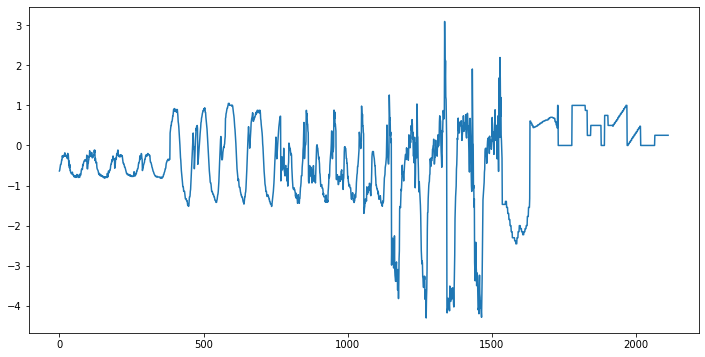

In [50]:
plt.figure(figsize=(12,6))
plt.plot(npTestMatrixWithAnom[45,:])

Text(0.5, 1.0, 'Anomaly Sample 2')

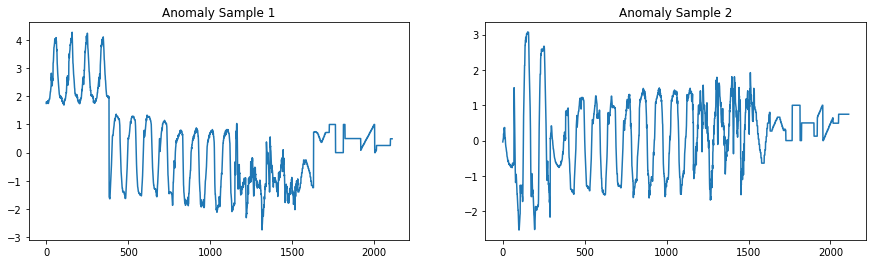

In [52]:
plt.figure(figsize=(15,4))
plt.plot(npTestMatrixWithAnom[103,:])

plt.subplot(1,2,1)
plt.plot(npTestMatrixWithAnom[112,:])
plt.title("Anomaly Sample 1")

plt.subplot(1,2,2)
plt.plot(npTestMatrixWithAnom[248,:])
plt.title("Anomaly Sample 2")

# Write Indices to Submission File

In [33]:
# Function to write anomaly indices to submission file

def write_submission_text_file(anomaly_row_indices, anomaly_start_col_indices, fileName):
    # Open file for writing
    fileHandle = open(fileName, "w")
    
    # For each line in indice arrays, write a line in the submission file
    for i in range(len(anomaly_row_indices)):
        lineStr = ""
        if (anomaly_start_col_indices[i] == -1): # Only row index, no start column index for anomaly
            lineStr = str(anomaly_row_indices[i]) + ",\n"
        else:
            lineStr = str(anomaly_row_indices[i]) + ", " + str(anomaly_start_col_indices[i]) + "\n"
    
        fileHandle.write(lineStr)
    
    # Close file stream operation
    fileHandle.close()


In [34]:
file_name = "team_syed_rizvi_submission.txt"
write_submission_text_file(anomaly_row_indices, anomaly_start_col_indices, file_name)

# Test Submission File Parsing

Make sure submission file is able to be parsed by code

In [35]:
def parse_submission ( filename ):
    dayIndicators = [] 
    startSampleIndicators = []
    lineCount = 0 
    with open(filename) as submission_text:
        line = submission_text.readline()        
        while line:
            if lineCount > 200: break
                    
            dayIndicators += [line.split(',')[0].strip()]
            startSampleIndicators += [line.split(',')[1].strip()]
            
            print( f'parsing line#{lineCount}: {line}' )
            line = submission_text.readline()
            lineCount += 1
            
    return dayIndicators, startSampleIndicators

In [1]:
#parse_submission ( 'team_syed_rizvi_submission.txt')

# File is being read correctly